# Exploratory Data Analysis


## Cleaning

In [128]:
import numpy as np
import pandas as pd
import datetime # manipulating date formats
import os

from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose,STL

# settings
plt.style.use('seaborn-deep')

In [129]:
ts = pd.read_csv("daily.csv", parse_dates=['timestamp'])
ts.head()

,Unnamed: 0,timestamp,reportingGroup,locationName,value,unit
0,0,2017-01-01,Electricity,1037 Vuotalo,1652.32,kWh
1,1,2017-01-02,Electricity,1037 Vuotalo,2145.28,kWh
2,2,2017-01-03,Electricity,1037 Vuotalo,2151.84,kWh
3,3,2017-01-04,Electricity,1037 Vuotalo,2489.12,kWh
4,4,2017-01-05,Electricity,1037 Vuotalo,2596.96,kWh


In [130]:
ts = ts[ts['unit'] != 'm3']
ts

,Unnamed: 0,timestamp,reportingGroup,locationName,value,unit
0,0,2017-01-01,Electricity,1037 Vuotalo,1652.32,kWh
1,1,2017-01-02,Electricity,1037 Vuotalo,2145.28,kWh
2,2,2017-01-03,Electricity,1037 Vuotalo,2151.84,kWh
3,3,2017-01-04,Electricity,1037 Vuotalo,2489.12,kWh
4,4,2017-01-05,Electricity,1037 Vuotalo,2596.96,kWh
...,...,...,...,...,...,...
615229,615229,2019-12-28,Electricity,"4046 Lp Hilleri, 25820 leikkipuisto",349.73,kWh
615230,615230,2019-12-29,Electricity,"4046 Lp Hilleri, 25820 leikkipuisto",306.35,kWh
615231,615231,2019-12-30,Electricity,"4046 Lp Hilleri, 25820 leikkipuisto",253.59,kWh
615232,615232,2019-12-31,Electricity,"4046 Lp Hilleri, 25820 leikkipuisto",275.06,kWh


Next, we clean the data and restructure it into a more suitable format.

* Group the `ts` dataframe by the locations since our data contain electricity demand records from multiple locations.

* For each location, we create a dataframe. The index of each of these dataframes are the timestamps of the data (from 2017-January-01 to 2020-January-01). These dataframes are stored in the list `locs`.

* For each dataframe, we delete the duplicated records if there are any.

In [131]:
groups = ts.groupby('locationName')

# divide into different dataframes for each location
locs = [groups.get_group(df).set_index('timestamp').value for df in groups.groups]

# remove duplicated rows
locs = [df[~df.index.duplicated(keep='first')] for df in locs]

Next, we further clean the data. As there may be locations whose data are not in hourly resolution, we need to reformat those dataframes so that all of them are in the hourly resolution.

In [132]:
# create a range of timestamps covering the time range of the data.
all_dates = pd.date_range(start='2017-01-01', end='2020-01-01', freq='D')

for idx, loc in enumerate(locs):
    if len(loc) > len(all_dates): # are there more records (timestamps) than the default dataframe
        locs[idx] = locs[idx].resample('D').sum()

Next, we combine all dataframes in `locs` into 1 big dataframe `df`, in which each column is a location.

In [133]:
ts = pd.concat(locs, join='outer', axis=1, ignore_index=True)
ts.head()

,0,1,2,3,4,5,6,7,8,9,...,571,572,573,574,575,576,577,578,579,580
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2005.76,969.10,233.00,1652.32,1023.70,258.63,91.08,559.20,0.94,225.60,...,567.42,1181.76,1081.59,1069.2,703.99,4700.0,5264.0,670.37,NaN,1131.0
2017-01-02,3081.50,995.34,788.95,2145.28,1508.15,457.95,214.32,634.51,0.95,525.04,...,1152.73,1653.48,1436.20,1459.6,1244.22,8900.0,5976.0,875.44,NaN,2512.0
2017-01-03,3176.77,1122.91,1067.80,2151.84,1501.27,477.70,208.48,682.64,0.94,550.96,...,1211.86,1674.48,1496.60,1184.4,1275.65,9300.0,6056.0,882.21,NaN,2620.0
2017-01-04,3173.77,956.25,1125.55,2489.12,1497.33,484.12,215.52,693.18,0.95,545.52,...,1119.05,1630.08,1471.29,1211.2,885.92,11900.0,5916.0,837.58,NaN,3277.0
2017-01-05,3204.18,932.25,1217.55,2596.96,1431.18,476.02,221.72,702.17,0.95,536.56,...,1048.96,1553.52,1426.89,1236.8,850.15,13000.0,5800.0,805.91,NaN,3810.0


Now, we can already spot that there are NaN entries in the dataframe. In other words, for those locations at those timestamps, there was no available data. Although it may be arbitrary, we decided to only take the columns (locations) in which there are less than 100 missing entries.

In [134]:
ts = ts.loc[:,ts.isna().sum() < 100]
ts.head()

,0,1,2,3,4,5,6,7,9,10,...,570,571,572,573,574,575,576,577,578,580
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2005.76,969.10,233.00,1652.32,1023.70,258.63,91.08,559.20,225.60,379.89,...,98.48,567.42,1181.76,1081.59,1069.2,703.99,4700.0,5264.0,670.37,1131.0
2017-01-02,3081.50,995.34,788.95,2145.28,1508.15,457.95,214.32,634.51,525.04,457.54,...,340.96,1152.73,1653.48,1436.20,1459.6,1244.22,8900.0,5976.0,875.44,2512.0
2017-01-03,3176.77,1122.91,1067.80,2151.84,1501.27,477.70,208.48,682.64,550.96,447.20,...,342.88,1211.86,1674.48,1496.60,1184.4,1275.65,9300.0,6056.0,882.21,2620.0
2017-01-04,3173.77,956.25,1125.55,2489.12,1497.33,484.12,215.52,693.18,545.52,546.25,...,301.68,1119.05,1630.08,1471.29,1211.2,885.92,11900.0,5916.0,837.58,3277.0
2017-01-05,3204.18,932.25,1217.55,2596.96,1431.18,476.02,221.72,702.17,536.56,456.44,...,276.08,1048.96,1553.52,1426.89,1236.8,850.15,13000.0,5800.0,805.91,3810.0


However, our data might still have missing timestamps, which is why we insert rows whose index are the missing timestamps.

As one solution to the missing entries problem, we decided to interpolate the data linearly, that is, for each column (location), the missing entries are filled with values that follow a linear trend to other entries. There are other interpolation methods as well, but we decided to go with this method. This interpolation should not affect the inference much as for each column there are only at most 100 missing entries, and the dataframe has more than 25000 rows.

After the interpolation step, we sum over all columns (locations) as we only wish to predict the hourly "total" electricity demand.

In [135]:
ts = ts.sort_index().interpolate().sum(axis=1).to_frame(name='kWh')
ts.index.rename('Date',inplace=True)
ts

,kWh
Date,
2017-01-01,393707.05
2017-01-02,538022.63
2017-01-03,549714.09
2017-01-04,548953.12
2017-01-05,545259.28
...,...
2019-12-28,462485.64
2019-12-29,442889.22
2019-12-30,519266.06


As a final step in this section, we save the aggregated data.

We start by reading the data and transform it to a suitable form. This means dropping unnecessary columns and setting the right data frequency.

We can see that there is a clear year over year seasonality, with some irregularities from the end of 2018 to the beginning of 2019. This may be due to the data gathering process at the source. Let us examine next if there is any need to clean the data.

In [136]:
print(ts.info())
ts.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2017-01-01 to 2020-01-01
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     1096 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB
None


,kWh
count,1096.000000
mean,508050.718476
std,94631.972830
min,313056.850000
25%,428946.617500
50%,522296.615000
75%,589724.655000
max,663211.580000


Fortunately, the data is already in good shape. We only need to save the data now.

<AxesSubplot:xlabel='Date'>

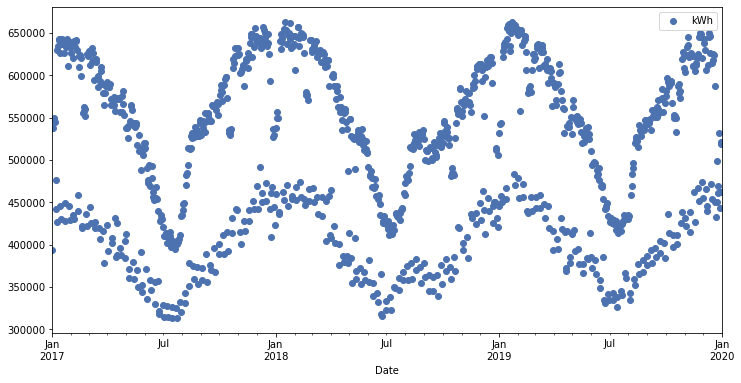

In [119]:
ts.plot(figsize = (12,6),style = 'o')

## Data Visualization

In [137]:
file_name = 'cleaned-daily.csv'
ts.to_csv(f"./{file_name}")

First, we can take a look at the consumption during each year.

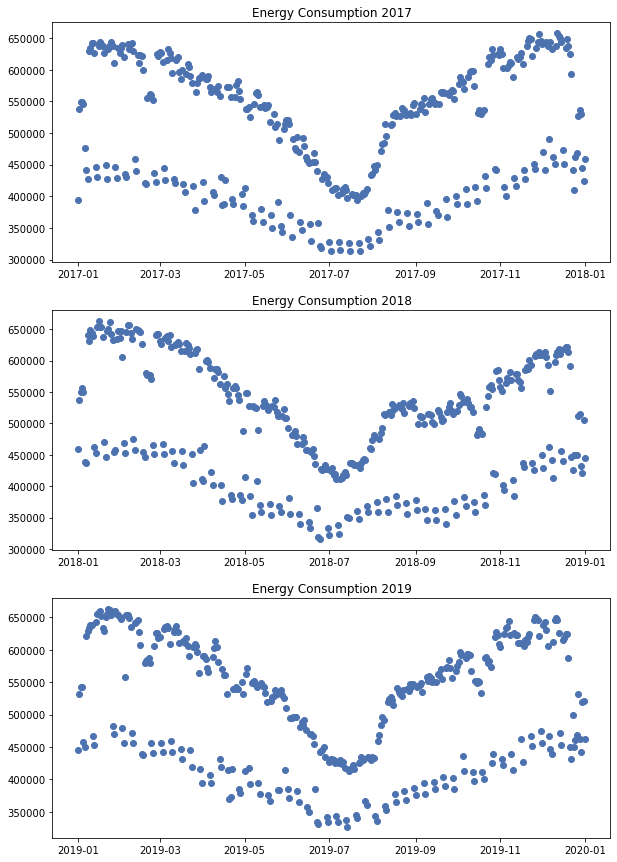

In [117]:
ts2017,ts2018,ts2019 = ts['2017-01-01':'2018-01-01'],ts['2018-01-01':'2019-01-01'],ts['2019-01-01':'2020-01-01']
fig,ax =  plt.subplots(3,figsize=(10,15))

ax[0].plot(ts2017,'o')
ax[0].set_title('Energy Consumption 2017')
ax[1].plot(ts2018,'o')
ax[1].set_title('Energy Consumption 2018')
ax[2].plot(ts2019,'o')
ax[2].set_title('Energy Consumption 2019')

plt.show()

The seasonality within each year is very much predictable. The demand peaks in winter-spring then bottoms out during summer.

We now proceed to zoom in the plot further, investigating monthly, weekly and daily time periods.

Text(0.5, 0.98, 'Energy Consumption in the January and February 2017')

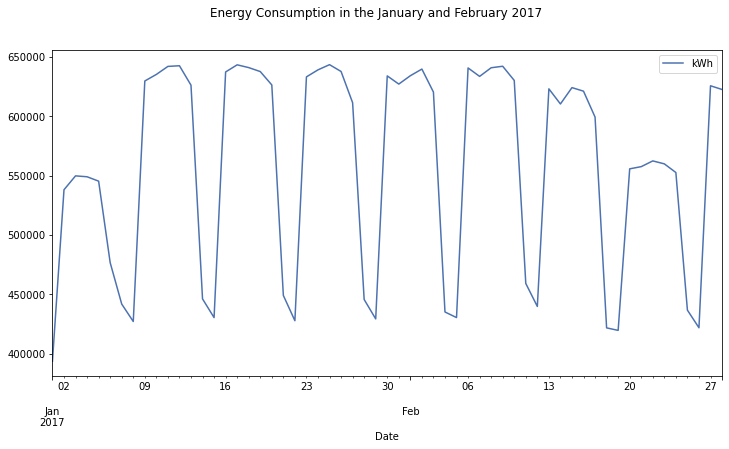

In [127]:
feb_end = '2017-02-28'

ts.loc[:feb_end].plot(figsize = (12,6))
plt.suptitle('Energy Consumption in the January and February 2017')

Upon examining the plot, we can see that there is a very visible pattern occuring every 7 days. Therefore, it can be deduced that there is a weekly seasonality within the time series. We can further explore this pattern by looking at the day of the weeks of the time period.

In [121]:
# The day of the week with Monday=0,..., Sunday=6
ts.loc[:feb_end].index.dayofweek

Int64Index([6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6,
            0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0,
            1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1],
           dtype='int64', name='Date')

From the result, we can see that energy consumption level is at its height during the weekdays, then drops significantly during the weekends. This very much fits our expectation, since factories and workplaces, which follow such a schedule, are places that consume the most energy.

In the following section, we will further investigate the time series by decomposing it in to the 3 components:
* Trend-cycle - increases or decreases within the data in the long-term or not of a fixed frequency. 
* Seasonal - pattern occurs when a time series is affected by seasonal factors.
* Residuals - the remainder after removing the 2 aforementioned components.

If we are looking at an additive decomposition, this can be mathematically formulated as
$$
y_t = S_t + T_t + R_t,
$$
where $y_t$ is the data, $S_t$ is the seasonal component, $T_t$ is the trend-cycle component, and $R_t$ is the remainder component, all at period $t$. Similarly, a multiplicative decomposition would be written as
$$
y_t = S_t \times T_t \times R_t.
$$

Further reading: [Forecasting: Principles and Practice - Rob J Hyndman and George Athanasopoulos](https://otexts.com/fpp2/components.html).

We first apply the classical decomposition method, which uses moving averages,  implemented in the class [seasonal_decompose](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) from the [statsmodels](https://www.statsmodels.org) package. For clarity, we only use a year of data.

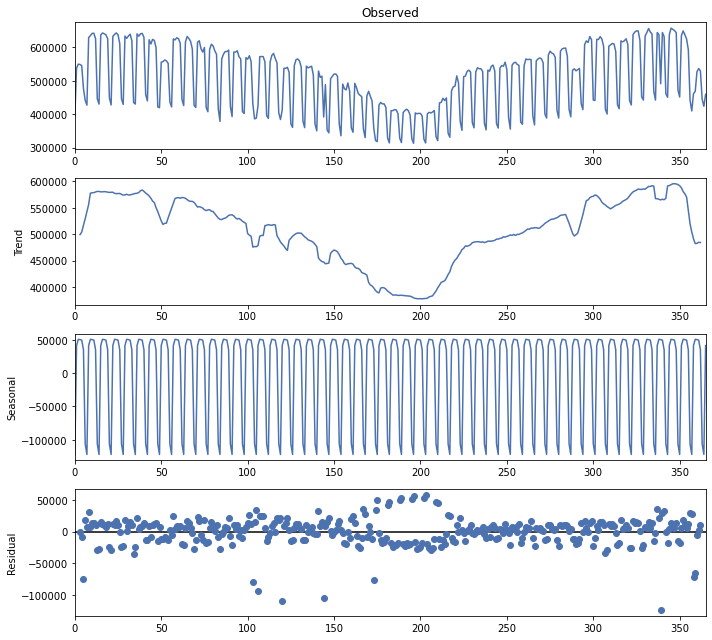

In [122]:
decompose = seasonal_decompose(ts2017.values, period = 7, model="additive")
plt.rcParams.update({'figure.figsize':(10,9)})
f = decompose.plot()


Now, we can see the trends and the seasonality clearly. And, the residuals resembles white noise to some extent, indicating that the model is a good fit. However, it also exhibits some abnormalities with clear patterns, especially in the summer period. This suggests that the residuals also erroneously take into account of the trend component, a "leakage". The problem mostly stems from this method of decomposition itself, being an outdated technique. 

Thus, we can overcome this by substituting it for a novel, more sophisticated decomposition method called STL decomposition. It is implemented in the class [STL](https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html) in the same package.

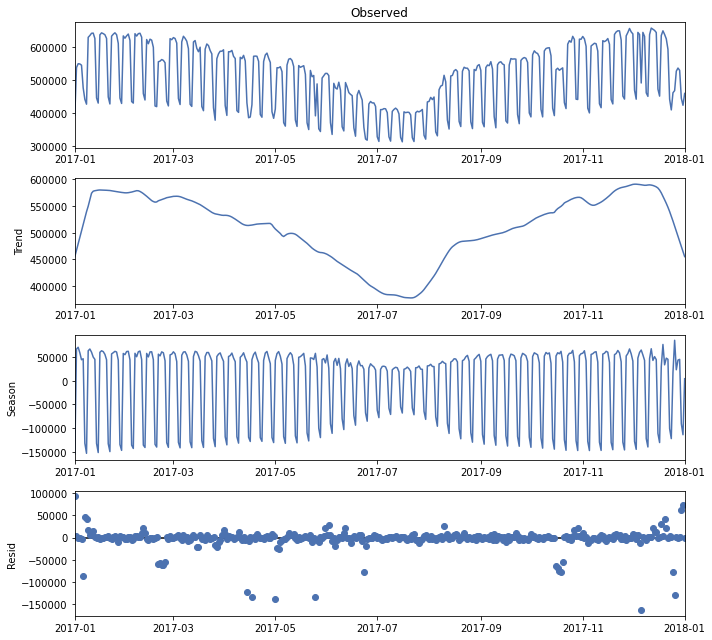

In [123]:
stl = STL(ts2017,seasonal=7,robust=True)
res = stl.fit()
fig = res.plot()

This project aims to predict aggregate electricity demand from a selected list of locations in the City of Helsinki by using the 3 leading methods: a classical Box-Jenkins model, a Deep Learning Neural Network, and a Facebook Prophet model.

The project itself is divided into 2 parts. The first one is about predicting daily electricity demand using the first 2 models. The second part use Facebook Prophet to do forecasting on hourly demand.

The data is fetched from the Nuuka open API, courtesy of Avoindata.fi. You can visit the project website here.We can see that the quality of the decomposition is much better. From this, we can see that the trends and seasonality are still very much present. Therefore, there are some detrending and deseasonalizing to do in the next step - modelling. 